<img src="./images/DLI_Header.png" style="width: 400px;">

# 測驗

恭喜你完成了今天的課程！希望你在過程中學到了一些實用技能，而且從中得到樂趣。該測試一下這些技能了。在這個測驗中，你要訓練出能夠辨識新鮮與腐壞水果的新模型。你必須讓模型的驗證準確度達到 `92%`才能通過測驗，但我們期望你可以盡力拿出更好的表現。你可以運用在前幾個練習中學到的技能。具體地說，我們建議使用一些結合遷移學習、資料增強和微調的方式。將模型訓練到在驗證資料集上有至少 92% 的準確度之後，請先儲存模型，然後再評估模型的準確度。現在就開始吧！

## 資料集

在這個練習中，你要訓練出可以辨識新鮮與腐壞水果的新模型。資料集來自 [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification)，如果你在本課程結束後有興趣展開新專案，這裡有絕佳的資源。資料集結構位於 `fruits`資料夾。其中共有六種類型的水果：新鮮蘋果、新鮮柳橙、新鮮香蕉、腐壞蘋果、腐壞柳橙和腐壞香蕉。這表示模型的輸出層必須有 6 個神經元，才能成功完成分類。你也需要運用 `categorical_crossentropy`來編寫模型，因為我們的類型超過兩種。

<img src="./images/fruits.png" style="width: 600px;">

## 載入 ImageNet 基本模型

建議你從 ImageNet 上預先訓練過的模型著手。載入具有正確權重的模型，接著設定輸入形狀，再選擇移除模型的最後一層。請記得，影像有三個維度：高度、寬度和多個色頻。由於這些圖片有色彩，因此會有紅色、綠色和藍色三個色頻。我們已經幫你填入了輸入形狀。請勿對此進行變更，否則將無法通過測驗。如果你需要設定預先訓練模型的參考資料，請參閱 [notebook 05b](05b_presidential_doggy_door.ipynb)，我們在這裡實作了遷移學習。

In [1]:
#VGG16與ResNet50，只預測一次且正確的機率0.715|0.759、預測五次只要一次猜對就算正確的機率0.901|0.929。參數的數量VGG16高5倍，愈多就須計算愈久
#https://ithelp.ithome.com.tw/articles/10192162

from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [2]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 凍結基本模型

接下來，我們建議你凍結基本模型，請依照 [notebook 05b](05b_presidential_doggy_door.ipynb) 中的做法。這麼做是為了避免所有來自 ImageNet 資料集的學習在初始訓練中遭到破壞。

In [3]:
# Freeze base model
base_model.trainable = False

In [4]:
#VG16 共16層(13個conv卷積層及3個全連接層)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 將各層新增至模型

現在將各層新增到預先訓練模型。可以將 [Notebook 05b](05b_presidential_doggy_door.ipynb) 當作操作指引。請密切注意最後的密集層，並確保這一層有正確數量的神經元，才能為不同類型的水果分類。

In [5]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer  
#
#扁平層(Flatten)：把多維的輸入壓扁為一維輸出，常用在從卷積層到全連接層的過渡
x = keras.layers.GlobalAveragePooling2D()(x)
# x = Flatten()(x) #Flatten應該是這樣，未試

# Add final dense layer    2是最終要判斷的種類。模型會回歸到全連接層(Dense)進行分類
outputs = keras.layers.Dense(2, activation = 'softmax')(x)
#outputs = keras.layers.Dense(1)(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


## 編寫模型

現在可以用損失和指標選項來編寫模型了。請記得，我們要針對許多不同的類別進行訓練，而不是要解決二元分類問題。

In [5]:

#model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])
model.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
#model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()],optimizer='adam')

## 增強資料

如果你願意，可以嘗試增強資料來改善資料集。歡迎參閱 [notebook 04a](04a_asl_augmentation.ipynb) 和 [notebook 05b](05b_presidential_doggy_door.ipynb) 來瞭解增強範例。此外，我們也有提供 [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) 的說明文件。你可以自行選擇是否要採取這個步驟，但這一步也許會有助於讓模型達到 92% 的準確度。

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## 載入資料集

現在該載入訓練和驗證資料集了。選擇適合的資料夾，以及適合的影像 `target_size`(必須與你建立的模型的高度和寬度輸入相符)。如果你需要參考資料，可以查看 [notebook 05b](05b_presidential_doggy_door.ipynb)。

In [7]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('mask/train/',
                                       target_size=(224, 224),  
                                       color_mode='rgb', 
                                       class_mode="categorical")
                                       #class_mode='binary', 
                                       #batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('mask/valid/',
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")
                                      #class_mode='binary', 
                                      #batch_size=8)


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'mask/train/'

In [52]:
#print(train_it.filepaths)
print(train_it.classes)
print(train_it.labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


## 訓練模型

In [53]:
print(train_it.samples/train_it.batch_size)
print(valid_it.samples/valid_it.batch_size)

1.21875
0.625


該訓練模型了！將 `train`和 `valid` 迭代器傳遞到 `fit` 函數，並且設定所需的 Epoch 數量。

In [55]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=20)

#model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=5)

Epoch 1/20
2/1 [=================================================] - 6s 3s/step - loss: 0.4318 - acc: 0.8205 - val_loss: 0.9007 - val_acc: 0.7000
Epoch 2/20
2/1 [=================================================] - 5s 3s/step - loss: 0.2326 - acc: 0.9231 - val_loss: 0.8135 - val_acc: 0.7500
Epoch 3/20
2/1 [=================================================] - 5s 2s/step - loss: 0.2342 - acc: 0.9231 - val_loss: 0.5966 - val_acc: 0.8500
Epoch 4/20
2/1 [=================================================] - 5s 2s/step - loss: 0.2488 - acc: 0.8718 - val_loss: 0.5439 - val_acc: 0.8000
Epoch 5/20
2/1 [=================================================] - 5s 3s/step - loss: 0.3033 - acc: 0.8718 - val_loss: 0.8757 - val_acc: 0.8500
Epoch 6/20
2/1 [=================================================] - 5s 3s/step - loss: 0.1673 - acc: 0.9487 - val_loss: 0.2935 - val_acc: 0.9500
Epoch 7/20
2/1 [=================================================] - 5s 3s/step - loss: 0.1877 - acc: 0.9231 - val_loss: 0.5

## 取消凍結模型以進行微調

如果驗證準確度已經達到 92%，你可以自行選擇是否要進行下個步驟。如果尚未達到，建議你以極低的學習率微調模型。

In [ ]:
#若上面的val accuracy已達目標 (>92%) ，就不用再微調
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
#調整完學習率，再訓練fit
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=5)


## 評估模型

在理想狀況下，現在你的模型驗證準確度應該會達到 92% 或以上。如果不是如此，建議你回到先前步驟執行更多 Epoch 的訓練，或是調整資料增強。

達到理想的驗證準確度後，請執行下列儲存格來評估模型。評估函數會回傳一個元組(Tuple)，其中第一個值表示損失，第二個值表示準確度。若要通過本測驗，模型的準確度值必須為 `92% or higher`。

In [56]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

1/0 [================================================] - 2s 2s/step - loss: 0.1435 - acc: 0.9500


[0.1766318678855896, 0.95]

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(454, 454, 3)


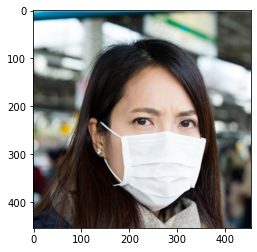

In [58]:
show_image("mask/valid/mask/投影片12.JPG")

In [59]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image


from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', predictions)
    print('===========================')
    
    maxp=0
    cato=0
    for i in range(len(predictions[0][:])):
        if predictions[0][i]>maxp:
            maxp=predictions[0][i]
            cato=i
    
    if cato==0:
        cato2='WITH MASK'
    elif cato==1:
        cato2='NO MASK'   
    elif cato==2:
        cato2='WITH MASK'   
    elif cato==3:
        cato2='rottenapples'           
    elif cato==4:
        cato2='rottenbanana'           
    elif cato==5:
        cato2='rottenoranges'           
        
    print(f'Cato={cato2}, Max pro={round(maxp*100,4)}%')      
    
    

(454, 454, 3)
Original image shape:  (454, 454, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[9.9946803e-01 5.3202413e-04]]
Cato=WITH MASK, Max pro=99.9468%


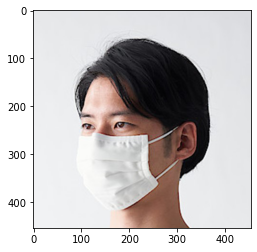

In [64]:
readable_prediction("mask/valid/mask/投影片24.JPG")

(266, 190, 3)
Original image shape:  (266, 190, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[0.01254041 0.98745954]]
Cato=NO MASK, Max pro=98.746%


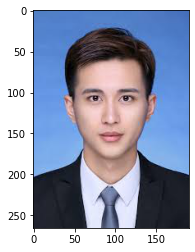

In [67]:
readable_prediction("mask/valid/no_mask/22.jpg")

## 執行測驗

若要測驗模型，請執行以下兩個儲存格。

**注意：** `run_assessment` 會假定你的模型名稱為 `model`，以及你的驗證資料迭代器名稱為 `valid_it`。若你修改了這些變數名稱，請更新傳遞至 `run_assessment`的引數名稱。

In [ ]:
from run_assessment import run_assessment

In [ ]:
run_assessment(model, valid_it)

## 產生證書

如果你通過測驗，請返回課程頁面 (如下所示)，然後按一下 [ASSESS TASK] (測驗工作) 按鈕，之後系統就會產生你的課程證書。

<img src="./images/assess_task.png" style="width: 800px;">